In [1]:
import warnings
import optuna
import prophet
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from src import UnivariateForecaster
from src.prophets import BaselineProphet, ProphetsEnsemble

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
prophet.diagnostics.logging.disable(level=50)
optuna.logging.set_verbosity(optuna.logging.ERROR)

#### EDA

In [3]:
data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv')

In [4]:
data.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [5]:
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data['y'] = data['y'].str.replace('\?', '').astype(float)

In [6]:
data.ds.max()

Timestamp('1990-12-31 00:00:00')

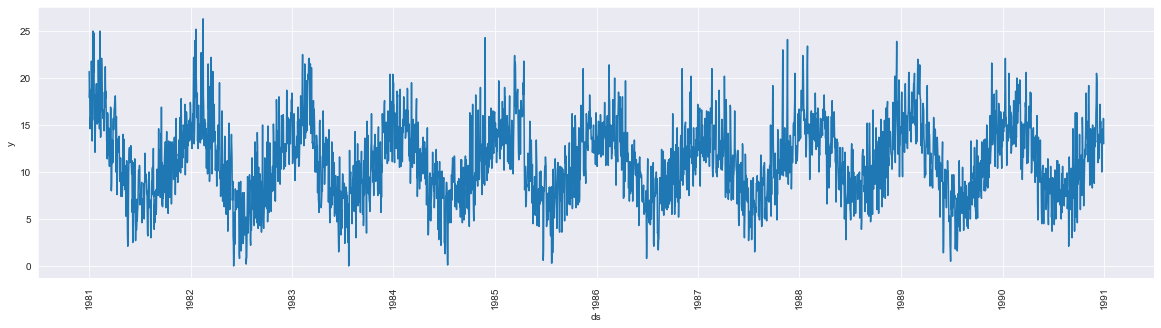

In [7]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='ds', y='y')
plt.xticks(rotation=90)
plt.show()

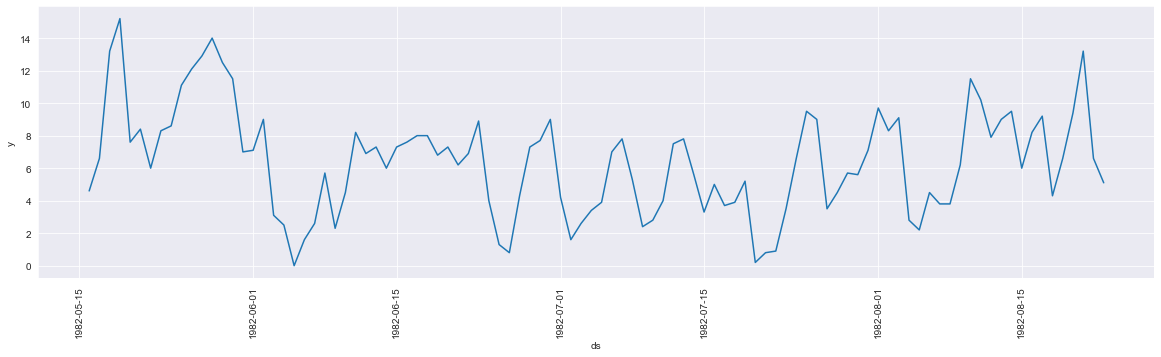

In [8]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data.iloc[500:600], x='ds', y='y')
plt.xticks(rotation=90)
plt.show()

In [9]:
ts = pd.date_range(start=data.ds.min(), end=data.ds.max(), freq='D')

len(ts) == len(data)

False

In [10]:
len(ts) - len(data)

2

#### Test-Train Split

In [11]:
train_series = data[data.ds < (data.ds.max() - timedelta(days=7))].copy()
test_series = data[data.ds >= (data.ds.max() - timedelta(days=7))].copy()

#### Useful functions

In [12]:
def draw_predictions(data: pd.DataFrame) -> None:
    series = data.set_index('ds').unstack().reset_index(drop=False)
    series.columns = ['type', 'ds', 'value']
    
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=series, x='ds', y='value', hue='type')
    plt.xticks(rotation=90)
    plt.show()

In [13]:
def show_metrics(data: pd.DataFrame, pred_column: str = 'yhat') -> None:
    print(f"Test RMSE: {np.sqrt(mean_squared_error(data['y'], data[pred_column]))}")
    print(f"Test MAPE: {np.sqrt(mean_absolute_percentage_error(data['y'], data[pred_column]))}")

#### Forecast

##### Baseline

In [14]:
fb = BaselineProphet(freq='D')
fb.fit(train_series)

In [15]:
forecast = fb.forecast(len(test_series) + 10)

In [16]:
forecast_df = test_series.copy()
forecast_df = forecast_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

In [17]:
show_metrics(forecast_df)

Test RMSE: 1.9422367253215727
Test MAPE: 0.3542233840337281


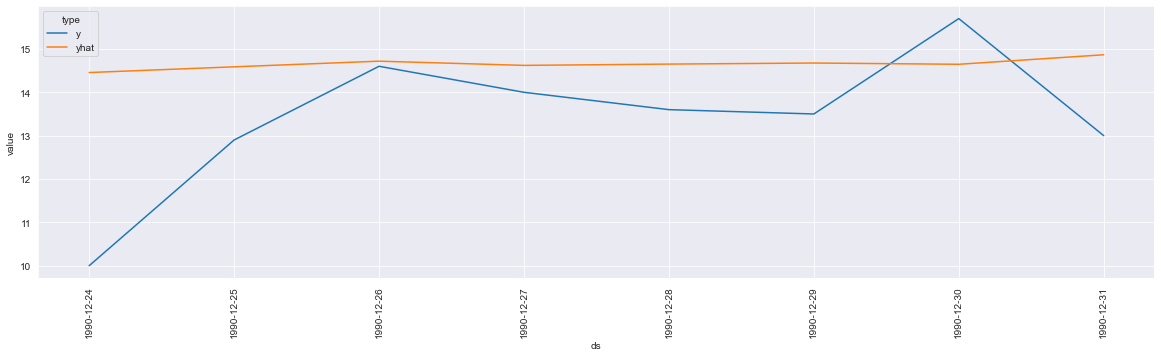

In [18]:
draw_predictions(forecast_df)

##### With LGBM

In [19]:
p = BaselineProphet(freq='D')
params = dict(n_estimators=1000, learning_rate=0.01, metric='rmse', seed=42)

model = UnivariateForecaster(p, params)

In [20]:
model.fit(train_series, len(test_series) + 10)

bagging, val_score: 2.673165: 100%|#############| 10/10 [00:09<00:00,  1.03it/s]
feature_fraction_stage2, val_score: 2.665575: 100%|#| 6/6 [00:06<00:00,  1.07s/i
regularization_factors, val_score: 2.665575: 100%|#| 20/20 [00:26<00:00,  1.30s/
min_data_in_leaf, val_score: 2.649774: 100%|######| 5/5 [00:05<00:00,  1.07s/it]


In [21]:
preds = model.forecast(test_series.drop('y', axis=1))

In [22]:
forecast_df['gbt_preds'] = preds

In [23]:
show_metrics(forecast_df, 'gbt_preds')

Test RMSE: 1.828266974593048
Test MAPE: 0.3256389039727192


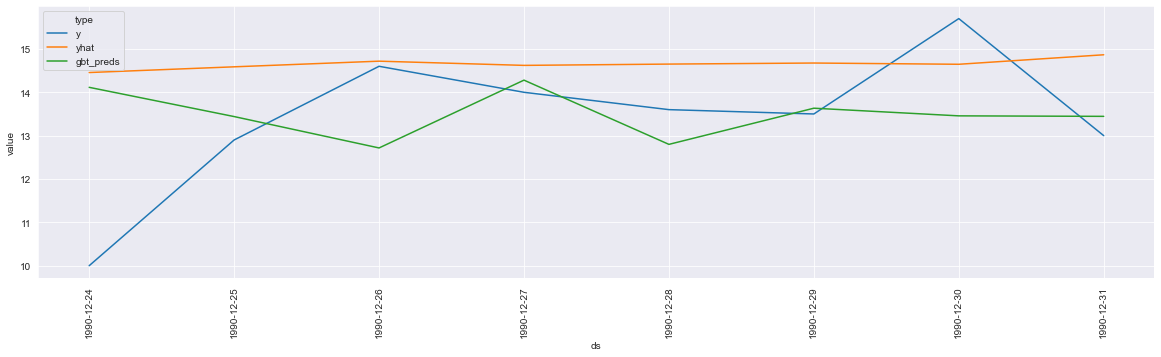

In [24]:
draw_predictions(forecast_df)

##### LGBM + Multilevel Prophets

In [25]:
pe = ProphetsEnsemble(freq='D', levels=['W', 'M'], agg_fn=['mean', 'median'])
params = dict(n_estimators=1000, learning_rate=0.01, metric='rmse', seed=42)

model = UnivariateForecaster(pe, params)

In [26]:
model.fit(train_series, len(test_series) + 10)

bagging, val_score: 2.582529: 100%|#############| 10/10 [00:25<00:00,  2.54s/it]
feature_fraction_stage2, val_score: 2.572371: 100%|#| 6/6 [00:12<00:00,  2.00s/i
regularization_factors, val_score: 2.568854: 100%|#| 20/20 [00:55<00:00,  2.75s/
min_data_in_leaf, val_score: 2.542792: 100%|######| 5/5 [00:12<00:00,  2.54s/it]


In [27]:
preds = model.forecast(test_series.drop('y', axis=1))

In [28]:
forecast_df['pe_preds'] = preds

In [29]:
show_metrics(forecast_df, 'pe_preds')

Test RMSE: 1.6927506212457937
Test MAPE: 0.33105886383347616


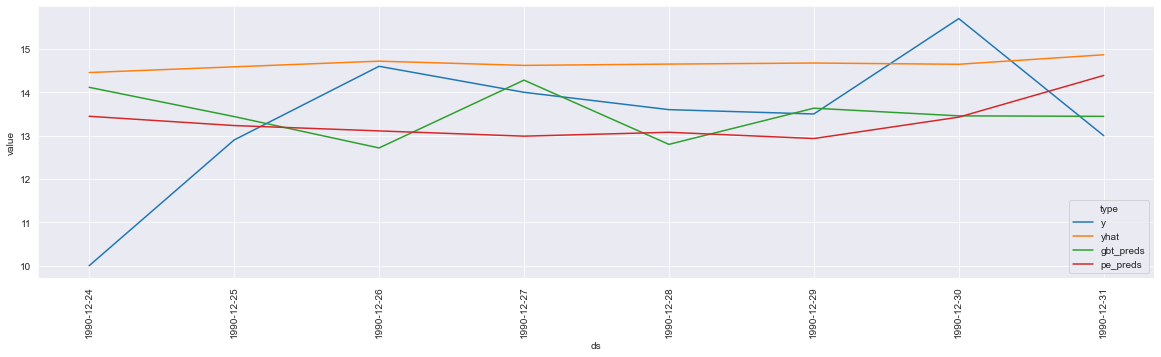

In [30]:
draw_predictions(forecast_df)